In [1]:
import os
from os.path import join

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from shapely.geometry import Polygon, Point
import numpy as np
import xarray as xr
from joblib import Parallel, delayed

from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn

from torchvision.models import efficientnet_b0
import geopandas as gpd

import matplotlib.pyplot as plt

device = "cuda"


In [2]:
gdf = gpd.read_file("/home/rishabh.mondal/Brick-Kilns-project/albk/experiments/data_preperation/shapefiles/statewise/DISTRICT_BOUNDARY.shp")
gdf.columns
gdf['District'] = gdf['District'].str.replace('>', 'A')
gdf['District'] = gdf['District'].str.replace('<', 'A')
gdf['STATE'] = gdf['STATE'].str.replace('>', 'A') 
gdf['STATE'] = gdf['STATE'].str.replace('<', 'A')

In [3]:
# state_gdf = gdf[gdf['STATE'] == 'BIHAR']
state_gdf = gdf[gdf['STATE'] == 'UTTAR PRADESH']
# delhi_gdf = gdf[gdf['STATE'] == 'PUNJAB']
state_gdf.head(60)

,District,STATE,REMARKS,State_LGD,DISTRICT_L,Shape_Leng,Shape_Area,geometry
13,AGRA,UTTAR PRADESH,None,9,118,787929.478603,3.902791e+09,"POLYGON ((3823318.714 4371451.435, 3823399.254..."
16,AL|GARH,UTTAR PRADESH,None,9,119,498779.443328,3.585997e+09,"POLYGON ((3792035.575 4455366.311, 3792139.285..."
21,AMBEDKARNAGAR,UTTAR PRADESH,None,9,121,384817.943754,2.242461e+09,"POLYGON ((4244093.138 4288731.854, 4244148.548..."
22,AMETHI,UTTAR PRADESH,None,9,640,396742.737994,2.336052e+09,"POLYGON ((4154715.142 4289236.170, 4155257.456..."
23,AMROHA,UTTAR PRADESH,None,9,154,364954.379714,2.379925e+09,"POLYGON ((3871324.808 4560362.064, 3871398.718..."
29,AURAIYA,UTTAR PRADESH,None,9,122,279215.510357,1.944745e+09,"POLYGON ((3939246.652 4319354.068, 3939361.372..."
30,AZAMGARH,UTTAR PRADESH,None,9,123,498671.919852,4.057542e+09,"POLYGON ((4286924.163 4264884.966, 4287385.646..."
31,BUDAUN,UTTAR PRADESH,None,9,133,449698.119253,4.112357e+09,"POLYGON ((3892522.532 4486653.948, 3892622.992..."
34,BAGHPAT,UTTAR PRADESH,None,9,124,218392.986381,1.281800e+09,"POLYGON ((3728186.204 4578755.701, 3728277.953..."
35,BAHRAICH,UTTAR PRADESH,None,9,125,578747.615415,4.776946e+09,"POLYGON ((4113776.583 4475298.537, 4114099.185..."


<Axes: >

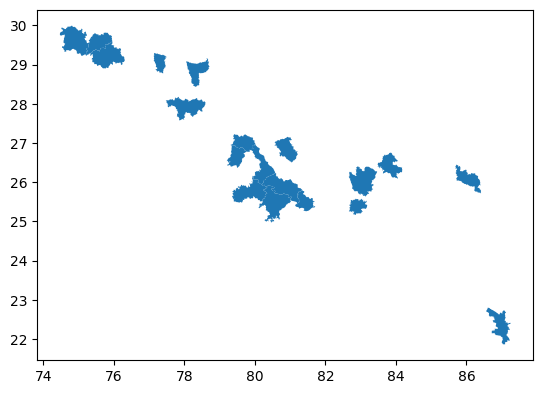

In [19]:
district = "LUCKNOW".upper()
district1 = "Banda".upper()
district2 = "Kanpur".upper()
district3 = "AL|GARH".upper()
deistrict4 = "Fatehpur".upper()
district5 = "DEORIA".upper()
district6 = "HAMIRPUR".upper()
district7 = "AURAIYA".upper()
district8="AMROHA".upper()
district9="AZAMGARH".upper()
district10="FATEHABAD".upper()
district11="FATEHPUR".upper()
district12="KAUSHAMBI".upper()
district13="KANNAUJ".upper()
district14="SIRSA".upper()
district15="VARANASI".upper()
district16="HARSHIPURA".upper()
district17="darbhanga".upper()
district18="JHARGRAM".upper()
district19="BAGHPAT".upper()
district20="HISAR".upper()
district21="SONIPAT".upper()

# district = "LUCKNOW"
custom_gdf = gdf[(gdf["District"] == district)|(gdf["District"] == district1)|(gdf["District"] == district2)|
                 (gdf["District"] == district3)|(gdf["District"] == deistrict4)|(gdf["District"] == district5)|
                 (gdf["District"] == district6)|(gdf["District"] == district7)|(gdf["District"] == district8)|
                 (gdf["District"] == district9)|(gdf["District"] == district10)|(gdf["District"] == district11)|
                 (gdf["District"] == district12)|(gdf["District"] == district13)|(gdf["District"] == district14)|
                 (gdf["District"] == district15)|(gdf["District"] == district16)|(gdf["District"] == district17)|
                 (gdf["District"] == district18)|(gdf["District"] == district19)|(gdf["District"] == district20)|(gdf["District"] == district21)]
state_gdf = state_gdf.to_crs(epsg=4326)
custom_gdf = custom_gdf.to_crs(epsg=4326)

custom_gdf.plot()

In [69]:
# import os

# path = "/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/predicted_positive/UTTAR_Pradesh/lucknow"

# files = os.listdir(path)
# file_names = []

# for file in files:
#     file_path = os.path.join(path, file)
#     if os.path.isfile(file_path):
#         file_names.append(file)

# print(file_names)
# file_list=[file.split('_')[:-2] for file in file_names]
# print(file_list)


In [72]:
path_lucknow = "/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/predicted_positive/UTTAR_Pradesh/lucknow"
path_banda = "/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/predicted_positive/UTTAR_Pradesh/banda"
path_kanpur = "/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/predicted_positive/UTTAR_Pradesh/KANPUR"
path_aligarg="/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/predicted_positive/UTTAR_Pradesh/AliGarh"
path_fatehpur="/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/predicted_positive/UTTAR_Pradesh/FATEHPUR"
path_deoria="/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/predicted_positive/UTTAR_Pradesh/DEORIA"
path_hamirpur="/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/predicted_positive/UTTAR_Pradesh/HAMIRPUR"
path_auraya="/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/predicted_positive/UTTAR_Pradesh/AURAIYA"
path_amroha="/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/predicted_positive/UTTAR_Pradesh/AMROHA"
path_azamgarh="/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/predicted_positive/UTTAR_Pradesh/AZAMGARH"

files_lucknow = os.listdir(path_lucknow)
files_banda = os.listdir(path_banda)
files_kanpur = os.listdir(path_kanpur)
files_aligarg = os.listdir(path_aligarg)
files_fatehpur = os.listdir(path_fatehpur)
files_deoria = os.listdir(path_deoria)
files_hamirpur = os.listdir(path_hamirpur)
files_auraya = os.listdir(path_auraya)
files_amroha = os.listdir(path_amroha)
files_azamgarh = os.listdir(path_azamgarh)
files_names_lucknow = [file.split('_')[:-2] for file in files_lucknow]
files_names_banda = [file.split('_')[:-2] for file in files_banda]
files_names_kanpur = [file.split('_')[:-2] for file in files_kanpur]
files_names_aligarg = [file.split('_')[:-2] for file in files_aligarg]
files_names_fatehpur = [file.split('_')[:-2] for file in files_fatehpur]
files_names_deoria = [file.split('_')[:-2] for file in files_deoria]
files_names_hamirpur = [file.split('_')[:-2] for file in files_hamirpur]
files_names_auraya = [file.split('_')[:-2] for file in files_auraya]
files_names_amroha = [file.split('_')[:-2] for file in files_amroha]
files_names_azamgarh = [file.split('_')[:-2] for file in files_azamgarh]
file_list=files_names_lucknow+files_names_banda+files_names_kanpur+files_names_aligarg+files_names_fatehpur+files_names_deoria+files_names_hamirpur+files_names_auraya+files_names_amroha+files_names_azamgarh
print(file_list)

[['26.77,80.98'], ['26.86,80.87'], ['26.96,80.87'], ['27.02,80.92'], ['26.77,81.17'], ['26.52,81.04'], ['26.62,81.10'], ['26.77,81.17'], ['26.69,81.06'], ['26.68,80.84'], ['26.69,81.07'], ['26.72,80.91'], ['26.69,80.85'], ['26.72,81.15'], ['26.75,81.02'], ['26.71,81.17'], ['26.77,80.89'], ['27.06,80.92'], ['26.71,81.17'], ['26.71,81.05'], ['26.71,81.21'], ['26.95,80.88'], ['26.54,81.06'], ['26.69,81.06'], ['26.96,80.88'], ['26.83,81.06'], ['26.90,81.03'], ['26.74,81.15'], ['26.81,81.02'], ['26.73,81.16'], ['26.69,80.81'], ['26.95,80.87'], ['26.74,81.16'], ['26.97,81.01'], ['26.81,81.01'], ['26.69,80.86'], ['27.02,80.91'], ['26.63,81.15'], ['26.69,81.06'], ['26.90,81.04'], ['26.68,80.85'], ['27.03,80.95'], ['26.95,80.90'], ['26.65,80.90'], ['27.13,80.93'], ['26.93,81.03'], ['26.54,81.04'], ['26.77,81.17'], ['27.03,80.91'], ['26.71,81.16'], ['26.70,81.19'], ['26.60,81.05'], ['27.02,80.92'], ['26.69,80.84'], ['26.59,81.00'], ['27.12,80.88'], ['26.72,81.16'], ['26.71,81.20'], ['26.67,80.95

[(26.77, 80.98), (26.86, 80.87), (26.96, 80.87), (27.02, 80.92), (26.77, 81.17), (26.52, 81.04), (26.62, 81.1), (26.77, 81.17), (26.69, 81.06), (26.68, 80.84), (26.69, 81.07), (26.72, 80.91), (26.69, 80.85), (26.72, 81.15), (26.75, 81.02), (26.71, 81.17), (26.77, 80.89), (27.06, 80.92), (26.71, 81.17), (26.71, 81.05), (26.71, 81.21), (26.95, 80.88), (26.54, 81.06), (26.69, 81.06), (26.96, 80.88), (26.83, 81.06), (26.9, 81.03), (26.74, 81.15), (26.81, 81.02), (26.73, 81.16), (26.69, 80.81), (26.95, 80.87), (26.74, 81.16), (26.97, 81.01), (26.81, 81.01), (26.69, 80.86), (27.02, 80.91), (26.63, 81.15), (26.69, 81.06), (26.9, 81.04), (26.68, 80.85), (27.03, 80.95), (26.95, 80.9), (26.65, 80.9), (27.13, 80.93), (26.93, 81.03), (26.54, 81.04), (26.77, 81.17), (27.03, 80.91), (26.71, 81.16), (26.7, 81.19), (26.6, 81.05), (27.02, 80.92), (26.69, 80.84), (26.59, 81.0), (27.12, 80.88), (26.72, 81.16), (26.71, 81.2), (26.67, 80.95), (26.77, 81.01), (26.72, 81.19), (26.71, 81.19), (26.65, 80.99), 

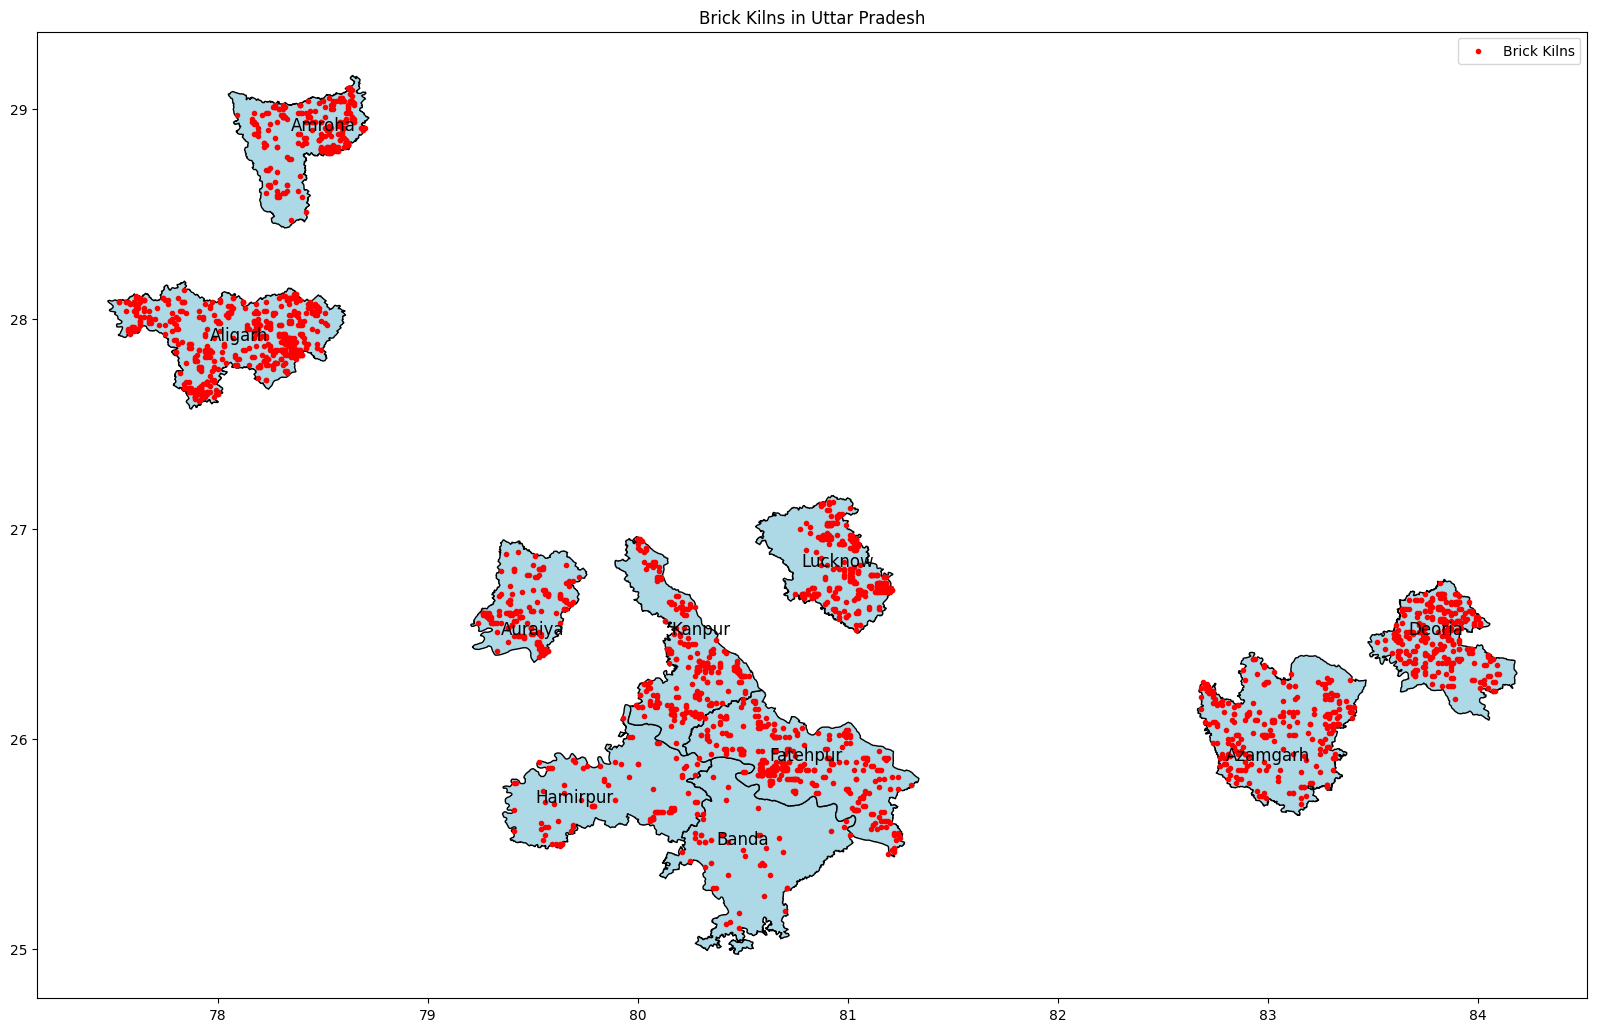

In [76]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Your list of coordinates
coordinates = file_list
# Extracting latitude and longitude from the coordinates list
points = [(float(coord[0].split(',')[0]), float(coord[0].split(',')[1])) for coord in coordinates]
print(points)
# Create a GeoDataFrame for the points
points_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy([point[1] for point in points], [point[0] for point in points]))
print(points_gdf)
# Plotting the custom_gdf
ax = custom_gdf.plot(color='lightblue', edgecolor='black', figsize=(20, 20))

# Plotting the points on the same plot
points_gdf.plot(ax=ax, color='red', marker='.',label='Brick Kilns')
ax.text(80.95, 26.82, 'Lucknow', color='black', fontsize=12, ha='center')
ax.text(80.5, 25.5, 'Banda', color='black', fontsize=12, ha='center')
ax.text(80.3, 26.5, 'Kanpur', color='black', fontsize=12, ha='center')
ax.text(78.1, 27.9, 'Aligarh', color='black', fontsize=12, ha='center')
ax.text(80.8, 25.9, 'Fatehpur', color='black', fontsize=12, ha='center')
ax.text(83.8, 26.5, 'Deoria', color='black', fontsize=12, ha='center')
ax.text(79.7, 25.7, 'Hamirpur', color='black', fontsize=12, ha='center')
ax.text(79.5, 26.5, 'Auraiya', color='black', fontsize=12, ha='center')
ax.text(78.5, 28.9, 'Amroha', color='black', fontsize=12, ha='center')
ax.text(83.0, 25.9, 'Azamgarh', color='black', fontsize=12, ha='center')

plt.legend()
plt.title('Brick Kilns in Uttar Pradesh')

# Display the plot
plt.show()